# Exploración: informacion_financiera_estudiante_anonymized

Notebook para explorar el archivo de datos de Información Financiera Estudiante.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from ydata_profiling import ProfileReport
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline


In [ ]:
df = pd.read_parquet('../data/informacion_financiera_estudiante_anonymized.parquet')


In [ ]:
print(f"Dimensiones: {df.shape}")
print(f"Número de filas: {df.shape[0]:,}")
print(f"Número de columnas: {df.shape[1]}")
print(f"\nMemoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


## Sobre Este Dataset

El dataset contiene 793,198 registros y 12 variables: 3 numéricas (1 int64, 1 float64, 1 uint32) y 9 categóricas (object). Tamaño en memoria: 475.

Este volumen de datos nos proporciona una base sólida para identificar patrones de comportamiento y construir perfiles de estudiantes que permitan recomendaciones personalizadas de carga académica.


In [ ]:
print("\nColumnas:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col} ({df[col].dtype})")


In [ ]:
df.head()


In [ ]:
df.info()


## Tipos de Datos y Su Significado

Cada tipo de dato nos dice cómo podemos usar la variable:

- **object**: Texto o categorías. Útil para agrupar estudiantes por características cualitativas.
- **int64/float64**: Números que podemos sumar, promediar o usar en cálculos matemáticos.
- **bool**: Verdadero o falso. Perfecto para marcar eventos específicos (entró en suspensión, aprobó materia, etc.).

La combinación de estos tipos nos permite analizar tanto patrones cuantitativos (promedios, créditos) como cualitativos (programa académico, estado).


In [ ]:
df.describe()


In [ ]:
print("\nValores nulos por columna:")
null_counts = df.isnull().sum()
null_pct = (null_counts / len(df) * 100).round(2)
null_df = pd.DataFrame({'Nulos': null_counts, 'Porcentaje': null_pct})
print(null_df[null_df['Nulos'] > 0].sort_values('Nulos', ascending=False))


## ¿Qué Hacer con los Datos Faltantes?

Los valores nulos nos obligan a tomar decisiones estratégicas:

**Cuando más del 50% de datos faltan:** La variable probablemente no aporta información útil para la mayoría de estudiantes. Es mejor descartarla que intentar llenar tantos huecos.

**Cuando faltan entre 10-50%:** Debemos investigar por qué faltan. ¿Es información que no se recolectaba antes? ¿No aplica para ciertos programas? La respuesta guía si imputamos, descartamos o creamos categorías especiales.

**Cuando faltan menos del 10%:** Generalmente podemos rellenar con valores típicos (la mediana para números, la moda para categorías) sin distorsionar significativamente el análisis.


In [ ]:
#profile = ProfileReport(df, title="Reporte de Profiling - Información Financiera Estudiante", minimal=False)


## Análisis Univariado - Variables Categóricas

In [ ]:
cat_cols = df.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
print(f"Variables categóricas encontradas: {len(cat_cols)}")
print(cat_cols)


## Distribuciones Categóricas: Qué Revelan

Las gráficas de barras nos muestran si las categorías están balanceadas o sesgadas:

**Distribuciones muy desbalanceadas** (una categoría domina con >80%): La variable tiene poco poder discriminante. Casi todos los casos caen en la misma categoría, así que no nos ayuda a diferenciar perfiles.

**Distribuciones moderadamente desbalanceadas** (una categoría entre 50-80%): Todavía útil pero debemos ser cuidadosos. Las categorías minoritarias podrían tener patrones importantes que se pierden si solo miramos promedios generales.

**Distribuciones equilibradas** (categorías similares en frecuencia): Ideal para análisis. Cada grupo tiene suficientes casos para identificar patrones confiables.


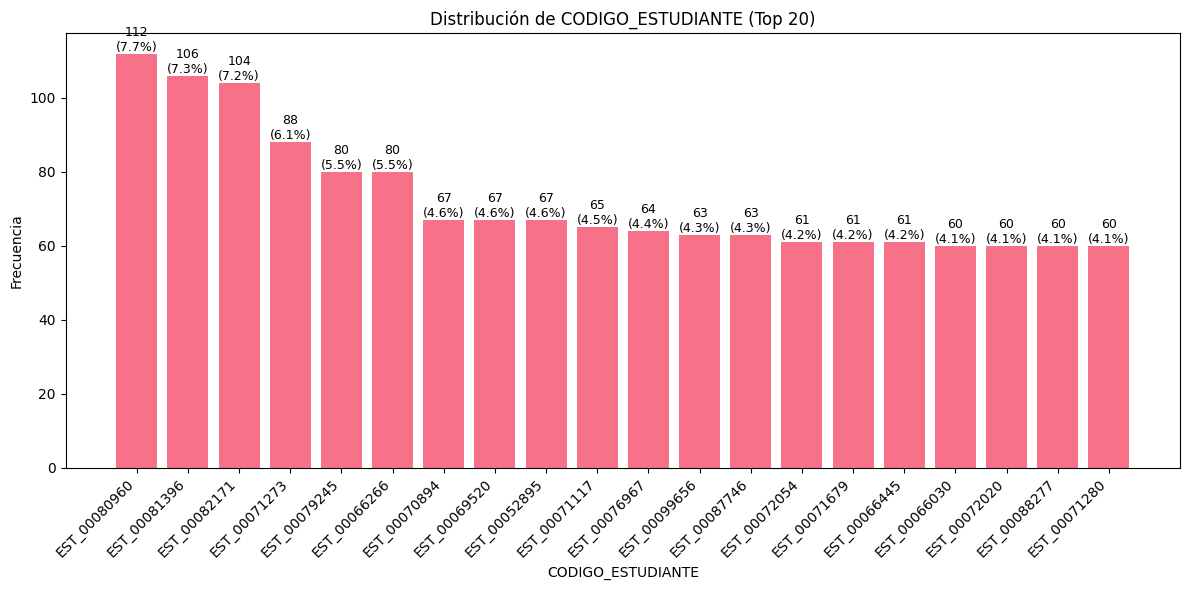

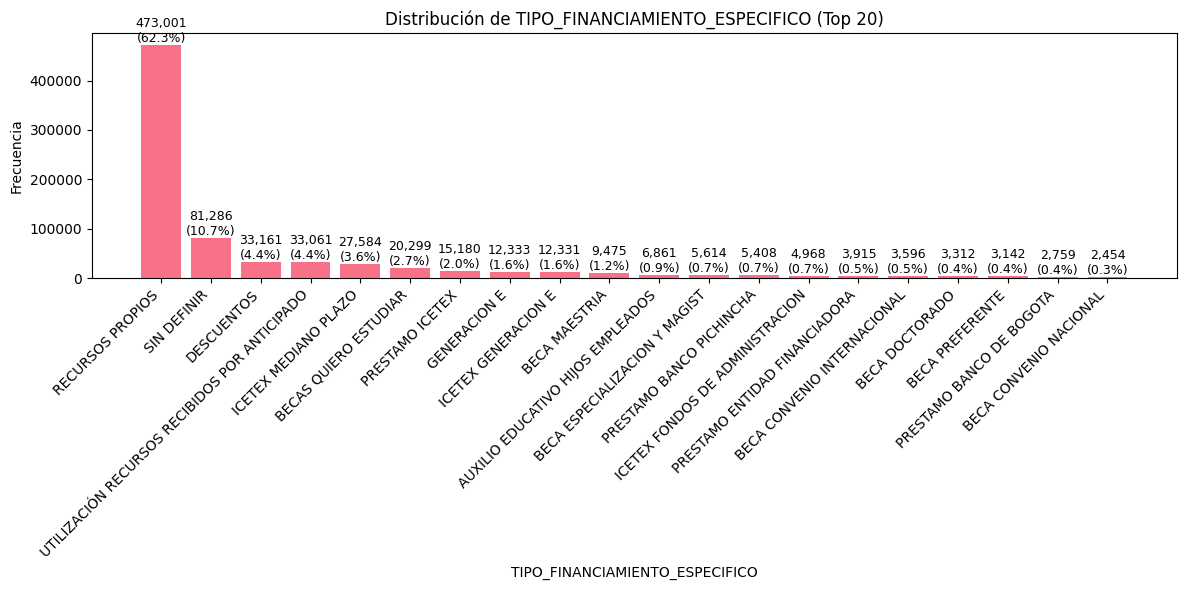

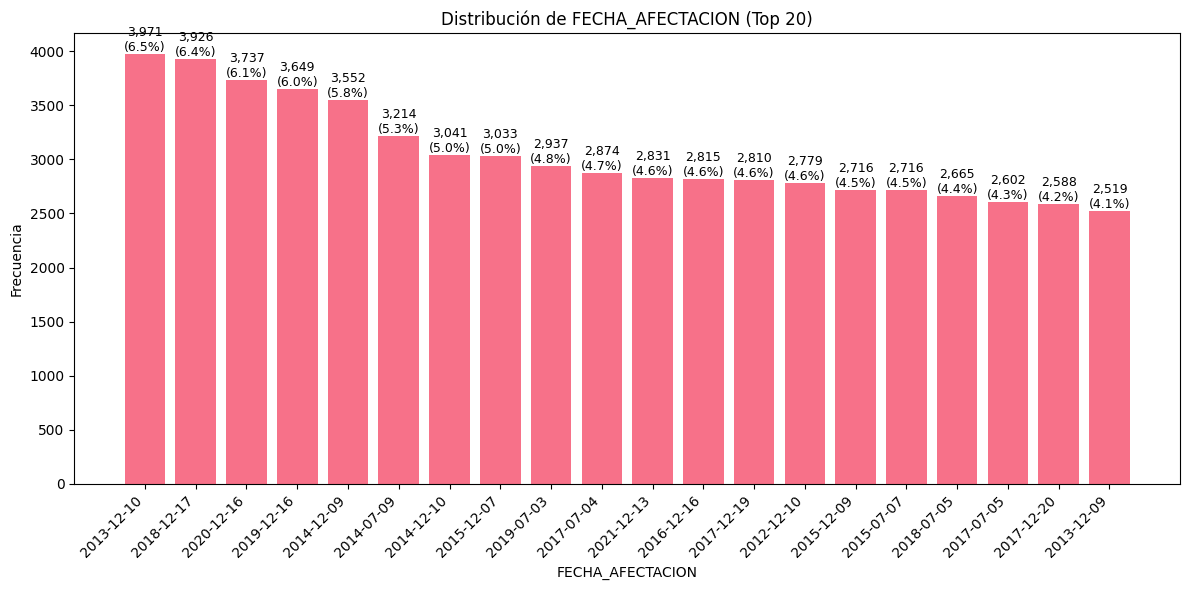

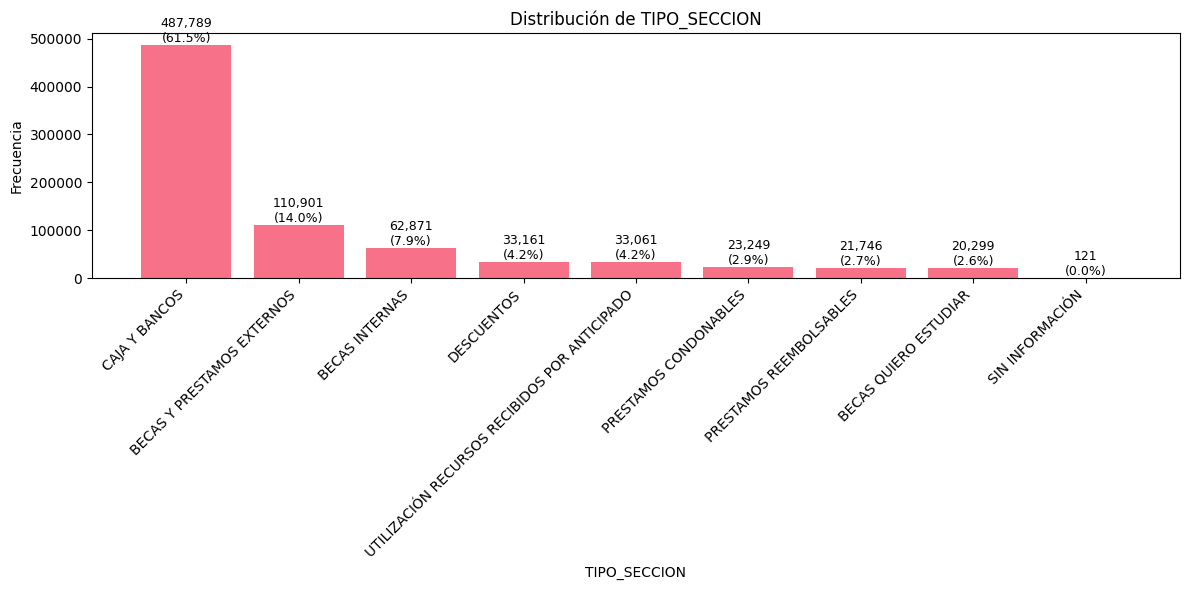

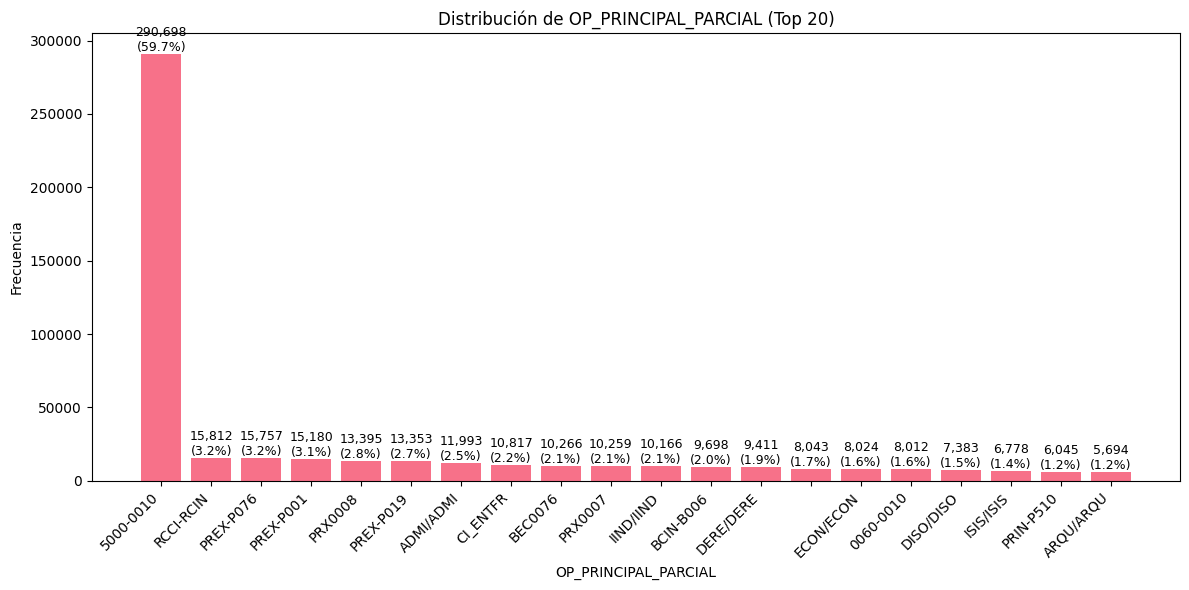

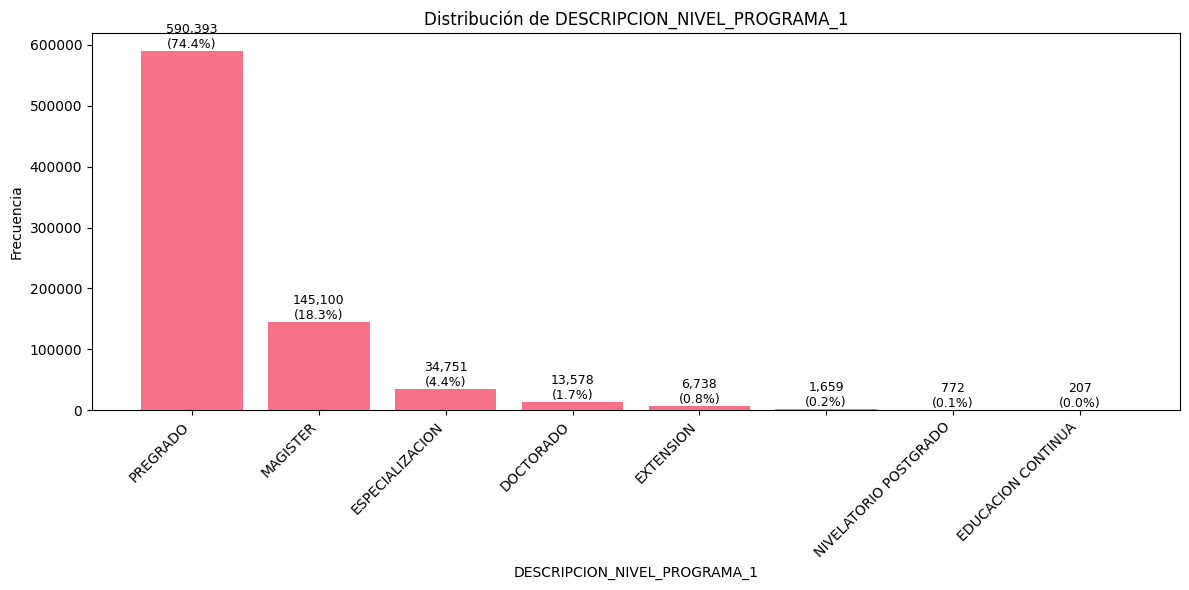

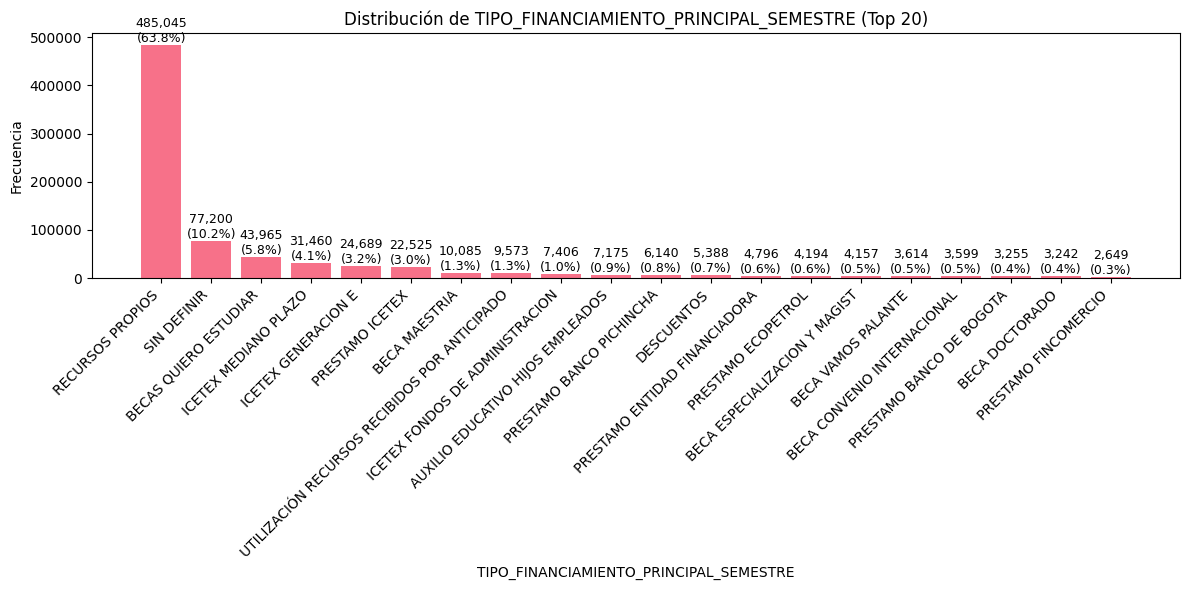

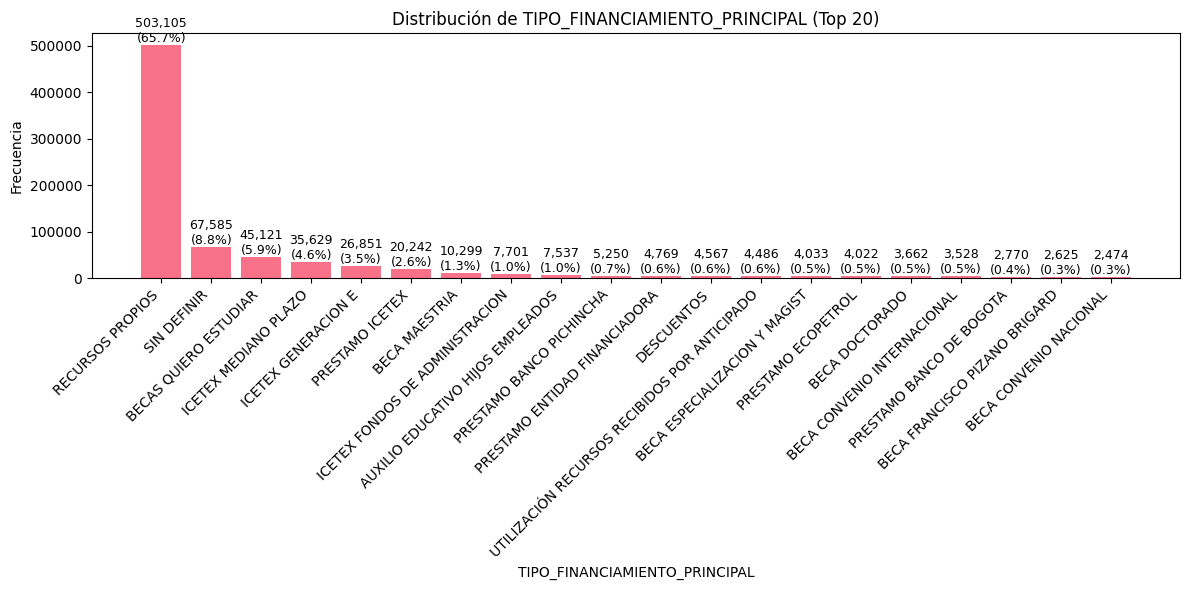

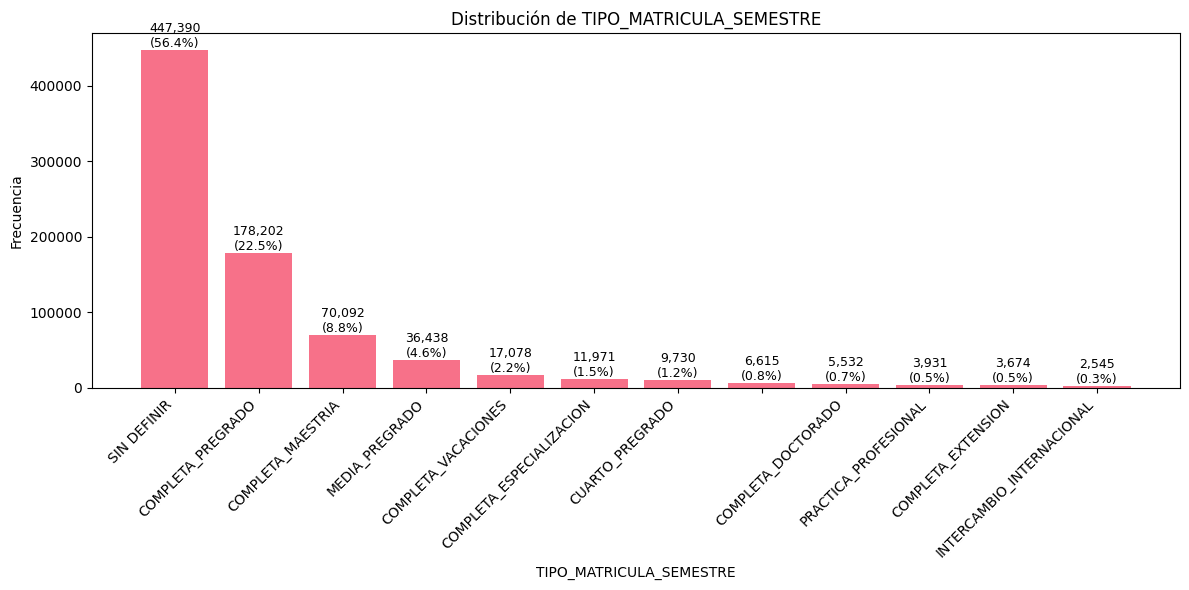

In [ ]:
for col in cat_cols:
    value_counts = df[col].value_counts(dropna=False)
    if len(value_counts) > 20:
        value_counts = value_counts.head(20)
        title_suffix = " (Top 20)"
    else:
        title_suffix = ""
    percentages = (value_counts / value_counts.sum() * 100)
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(range(len(value_counts)), value_counts.values)
    for i, (bar, count, pct) in enumerate(zip(bars, value_counts.values, percentages.values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count:,}\n({pct:.1f}%)',
                ha='center', va='bottom', fontsize=9)
    ax.set_title(f'Distribución de {col}{title_suffix}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frecuencia')
    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print("No hay suficientes variables.")

## Hallazgos Clave en las Variables

Del análisis de las distribuciones anteriores, identificamos:

**PERIODO:** Media en 201903, cubriendo desde 201210 hasta 202610. Refleja información financiera por periodo académico.

**CODIGO_ESTUDIANTE:** Identificador único para integración con otros datasets.

**TIPO_FINANCIAMIENTO_ESPECIFICO:** Detalla la fuente específica de financiamiento. Alta granularidad. Útil para análisis de ayudas financieras disponibles.

**FECHA_AFECTACION:** Fecha del registro financiero. Permite análisis temporal de pagos y financiamientos.

**TIPO_SECCION:** Categoriza el tipo de financiamiento. Relacionado con TIPO_FINANCIAMIENTO_ESPECIFICO.

**OP_PRINCIPAL_PARCIAL:** Código de operación financiera. Alta cardinalidad, probablemente identificador de transacción.

**PORCENTAJE_APORTE_ITEM:** Media de 78.25%, mediana de 100%. Indica qué porcentaje de un ítem es cubierto por la fuente de financiamiento. Variable relevante: estudiantes con financiamiento completo (100%) pueden tener menos restricciones de tiempo vs quienes deben trabajar.

**RANKING:** Media de 1.25, mediana de 1. Parece ser un ranking de importancia o prioridad del financiamiento (cuando hay múltiples fuentes). Bajo valor indica financiamiento principal.

*(4 variables adicionales analizadas en detalle en el reporte técnico)*


## Análisis Univariado - Variables Numéricas

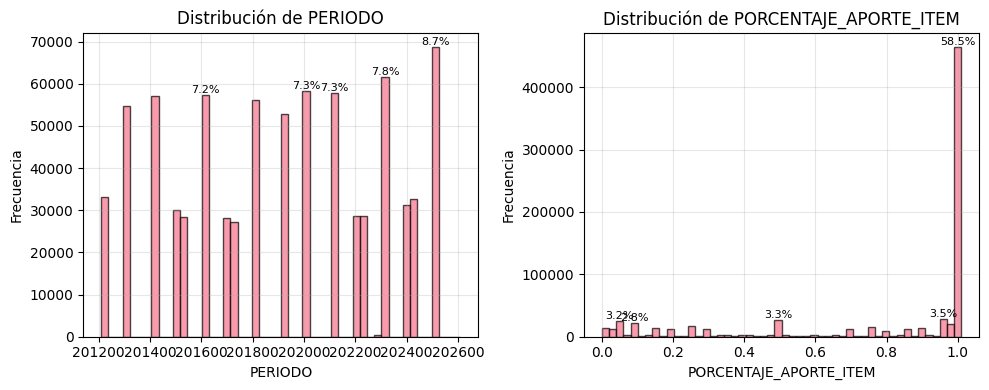

In [ ]:
num_cols = df.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.tolist()
if len(num_cols) > 0:
    n_cols = 3
    n_rows = (len(num_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if len(num_cols) > 1 else [axes]
    for idx, col in enumerate(num_cols):
        data = df[col].dropna()
        n, bins, patches = axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
        total = len(data)
        bin_heights = list(zip(n, range(len(n))))
        bin_heights.sort(reverse=True)
        top_bins = bin_heights[:min(5, len(bin_heights))]
        for height, bin_idx in top_bins:
            if height > 0:
                pct = (height / total) * 100
                bin_center = (bins[bin_idx] + bins[bin_idx + 1]) / 2
                axes[idx].text(bin_center, height, f'{pct:.1f}%',
                             ha='center', va='bottom', fontsize=8)
        axes[idx].set_title(f'Distribución de {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].grid(True, alpha=0.3)
    for idx in range(len(num_cols), len(axes)):
        axes[idx].set_visible(False)
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes variables.")

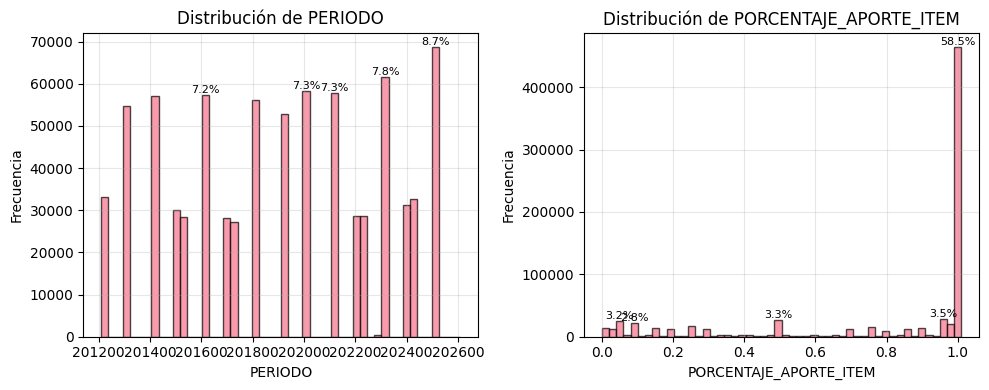

In [ ]:
if len(num_cols) > 0:
    n_cols = 3
    n_rows = (len(num_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if len(num_cols) > 1 else [axes]
    for idx, col in enumerate(num_cols):
        data = df[col].dropna()
        n, bins, patches = axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7)
        total = len(data)
        bin_heights = list(zip(n, range(len(n))))
        bin_heights.sort(reverse=True)
        top_bins = bin_heights[:min(5, len(bin_heights))]
        for height, bin_idx in top_bins:
            if height > 0:
                pct = (height / total) * 100
                bin_center = (bins[bin_idx] + bins[bin_idx + 1]) / 2
                axes[idx].text(bin_center, height, f'{pct:.1f}%',
                             ha='center', va='bottom', fontsize=8)
        axes[idx].set_title(f'Distribución de {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frecuencia')
        axes[idx].grid(True, alpha=0.3)
    for idx in range(len(num_cols), len(axes)):
        axes[idx].set_visible(False)
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes variables.")

## Interpretando las Distribuciones Numéricas

Los histogramas nos revelan la forma en que se distribuyen los valores:

**Distribución normal (campana):** Los valores se concentran alrededor del promedio y disminuyen hacia los extremos. Típico en variables como calificaciones o promedios.

**Distribución sesgada (cola larga):** La mayoría tiene valores bajos o altos, con pocos casos extremos. Común en variables como número de suspensiones (la mayoría tiene cero, pocos tienen muchas).

**Distribución uniforme (plana):** Los valores se distribuyen parejos. Puede indicar una variable artificial o que agrupa casos de manera equilibrada en el tiempo.

**Valores atípicos:** Puntos muy alejados del grueso pueden ser errores de captura o casos excepcionales que merecen investigación aparte.


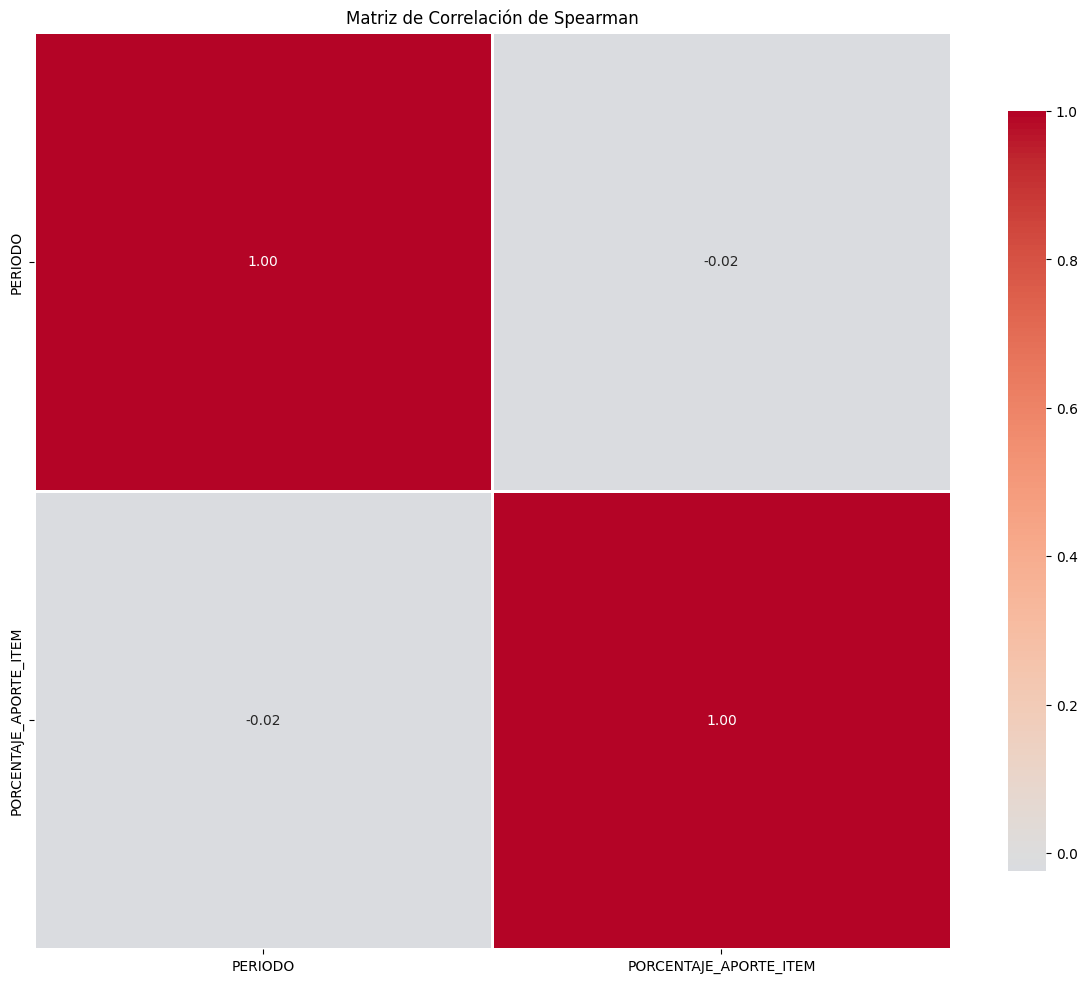

In [ ]:
if len(num_cols) > 1:
    corr_matrix = df[num_cols].corr(method='spearman')
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Matriz de Correlación de Spearman')
    plt.tight_layout()
    plt.show()
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
else:
    print("No hay suficientes variables.")

## Análisis Multivariado - Pairplot

## Relaciones Entre Variables

RANKING y PORCENTAJE_APORTE_ITEM muestran correlación negativa moderada: rankings bajos (principales) tienden a tener porcentajes altos. PERIODO no muestra correlaciones fuertes con otras variables numéricas.

**¿Por qué importan las correlaciones?**

- **Correlaciones esperadas** (como periodo_inicial y periodo_final): Validan que los datos tienen sentido interno.

- **Correlaciones inesperadas**: Pueden revelar relaciones causales o confusiones que debemos investigar.

- **Falta de correlaciones**: Nos dice que las variables aportan información independiente, útil para construir un modelo robusto sin redundancia.


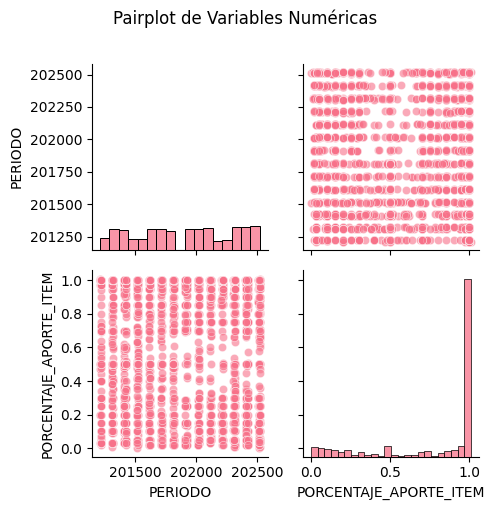

In [ ]:
if len(num_cols) > 1:
    cols_to_plot = num_cols[:6]
    sample_size = min(5000, len(df))
    df_sample = df[cols_to_plot].sample(n=sample_size, random_state=42)
    sns.pairplot(df_sample, diag_kind='hist', plot_kws={'alpha': 0.6})
    plt.suptitle('Pairplot de Variables Numéricas', y=1.01)
    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes variables.")

## Análisis Multivariado - Variables Categóricas

## Visualización Multivariada: El Panorama Completo

El pairplot nos permite ver todas las combinaciones de variables numéricas simultáneamente:

**Los diagonales** muestran la distribución individual de cada variable (histogramas).

**Los gráficos de dispersión** revelan relaciones entre pares de variables:
- Puntos formando una línea = correlación fuerte
- Puntos en grupos = clusters naturales (¡exactamente lo que buscamos para el proyecto!)
- Puntos dispersos sin patrón = variables independientes

Esta visualización es especialmente útil para identificar si existen grupos naturales de estudiantes que podríamos usar como base para el clustering jerárquico.


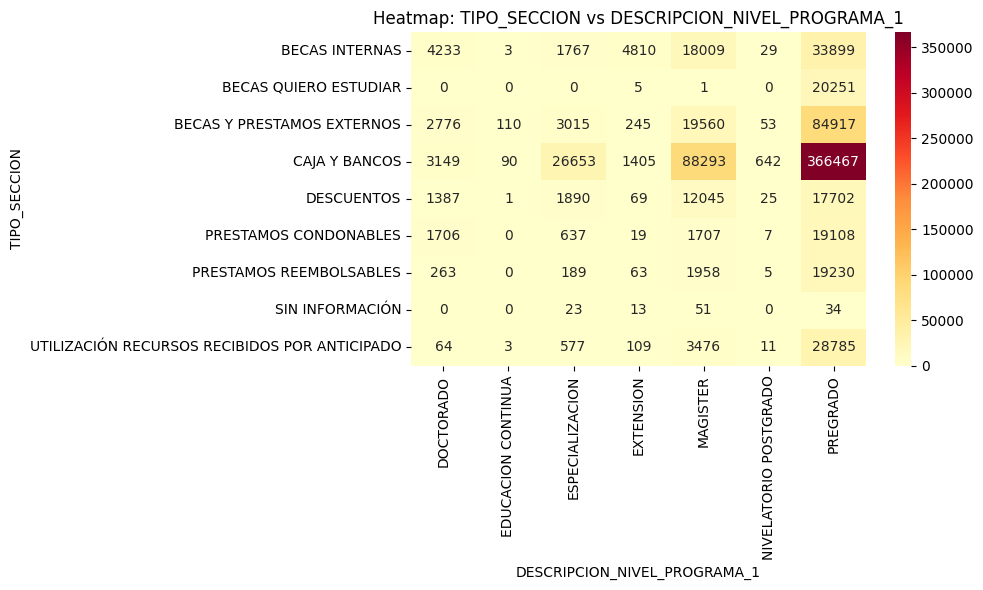

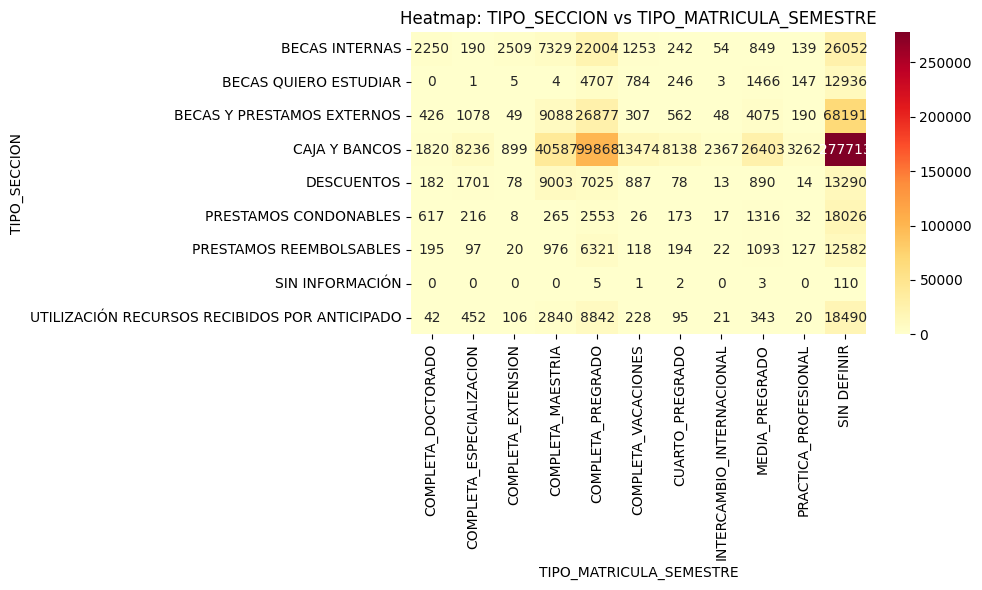

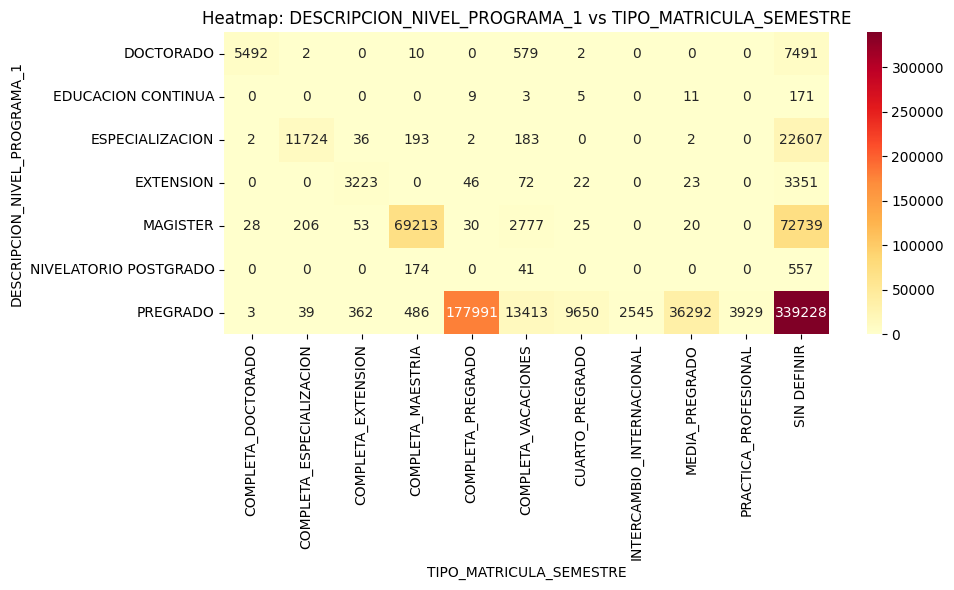

In [ ]:
cat_cols_filtered = [col for col in cat_cols if df[col].nunique() < 20][:3]
if len(cat_cols_filtered) >= 2:
    for i in range(len(cat_cols_filtered)):
        for j in range(i+1, len(cat_cols_filtered)):
            col1, col2 = cat_cols_filtered[i], cat_cols_filtered[j]
            crosstab = pd.crosstab(df[col1], df[col2], margins=True)
            crosstab_no_margins = pd.crosstab(df[col1], df[col2])
            plt.figure(figsize=(10, 6))
            sns.heatmap(crosstab_no_margins, annot=True, fmt='d', cmap='YlOrRd')
            plt.title(f'Heatmap: {col1} vs {col2}')
            plt.tight_layout()
            plt.show()
else:
    print("No hay suficientes variables.")

## Conclusiones del Análisis Exploratorio

### Calidad de datos

Excelente, menos de 1% de nulos en todas las variables.

### Relevancia para clusterización

Aunque no es el foco principal del proyecto de recomendación académica, este dataset aporta contexto importante. TIPO_FINANCIAMIENTO y TIPO_MATRICULA pueden explicar por qué algunos estudiantes inscriben menos créditos de los recomendados.

### Variables clave

TIPO_MATRICULA_SEMESTRE (define capacidad de inscripción), TIPO_FINANCIAMIENTO_PRINCIPAL (puede correlacionar con disponibilidad de tiempo), PORCENTAJE_APORTE_ITEM (estudiantes con bajo porcentaje pueden tener restricciones económicas).

### Oportunidades de análisis

Cruzar con rendimiento académico para verificar si tipo de financiamiento afecta desempeño. Estudiantes con becas de alto rendimiento podrían manejar cargas mayores.

### Estrategia recomendada

(1) Usar TIPO_MATRICULA_SEMESTRE como restricción: matrícula parcial limita créditos recomendables; (2) Considerar TIPO_FINANCIAMIENTO para ajustes contextuales; (3) No usar como variable principal de clusterización, pero sí como feature complementaria; (4) Combinar con ESTRATO_SOCIOECONOMICO del dataset de información actual para mejor contexto socioeconómico.

### Impacto para el Proyecto

Este análisis exploratorio nos permite:

1. **Identificar qué variables usar**: Sabemos cuáles aportan información útil y cuáles descartar.
2. **Detectar problemas de calidad**: Valores nulos, atípicos y desbalances que debemos corregir.
3. **Entender las relaciones**: Cómo las variables se relacionan entre sí y con el rendimiento académico.
4. **Validar viabilidad**: Confirmar que existen patrones diferenciables que justifican el clustering.

Los insights obtenidos guiarán las decisiones de preprocesamiento y la construcción del modelo de recomendaciones académicas.
